In [1]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)

Warning message:
"'timedatectl' indicates the non-existent timezone name 'n/a'"
unable to deduce timezone name from 'America/Chicago'

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts --------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


Loading required package: limma



In [2]:
Annotations <- read_tsv("../data/IntronAnnotationsFromYang.tsv.gz")
Long.table <- fread("../code/ReadLengthMapExperimentResults/JuncCountsTidy/LongTable.txt.gz") %>%
  dplyr::select(-OldAnnotation) %>% distinct()
Long.table.summarised <- Long.table %>%
  dplyr::select(Dataset:strand) %>%
  inner_join(Annotations) %>%
  filter(!SuperAnnotation %in% c("AnnotatedJunc_NoncodingGene", "UnannotatedJunc_NoncodingGene")) %>%
  group_by(SuperAnnotation, Dataset, IndID) %>%
  summarise(Sum=sum(score))
P.dat <- inner_join(
           Long.table.summarised,
           Long.table.summarised %>%
               group_by(IndID, Dataset) %>%
               summarise(TotalCounts = sum(Sum))
) %>%
  ungroup() %>%
mutate(Percent = Sum/TotalCounts*100) %>%
    mutate(Dataset = recode(Dataset, "chRNA.Expression.Splicing"="chRNA", "Expression.Splicing"="polyA", "MetabolicLabelled.30min"="30min", "MetabolicLabelled.60min"="60min")) %>%
    mutate(Dataset = factor(Dataset, levels=c("chRNA","30min", "60min", "polyA")))



-- Column specification -----------------------------------------------------------------------------------------------------------------------------------------------------------------------
cols(
  chrom = col_character(),
  start = col_double(),
  end = col_double(),
  strand = col_character(),
  NewAnnotation = col_character(),
  gene = col_character(),
  symbol = col_character(),
  SuperAnnotation = col_character(),
  SemiSupergroupAnnotations = col_character()
)

Joining with `by = join_by(chrom, start, end, strand)`
`summarise()` has grouped output by 'SuperAnnotation', 'Dataset'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'IndID'. You can override using the `.groups` argument.
Joining with `by = join_by(Dataset, IndID)`


In [5]:
Long.table.summarised %>% filter(Dataset=='chRNA.Expression.Splicing', IndID == 'NA19200')

SuperAnnotation,Dataset,IndID,Sum
<chr>,<chr>,<chr>,<int>
AnnotatedJunc_ProductiveCodingGene,chRNA.Expression.Splicing,NA19200,2058786
AnnotatedJunc_UnproductiveCodingGene,chRNA.Expression.Splicing,NA19200,58419
UnannotatedJunc_ProductiveCodingGene,chRNA.Expression.Splicing,NA19200,1931
UnannotatedJunc_UnproductiveCodingGene,chRNA.Expression.Splicing,NA19200,14029


In [5]:
P.dat %>% head()

SuperAnnotation,Dataset,IndID,Sum,TotalCounts,Percent
<chr>,<fct>,<chr>,<int>,<int>,<dbl>
AnnotatedJunc_ProductiveCodingGene,polyA,NA18486,6739246,6796931,99.15131
AnnotatedJunc_ProductiveCodingGene,polyA,NA18498,6093369,6140438,99.23346
AnnotatedJunc_ProductiveCodingGene,polyA,NA18499,4641750,4677677,99.23195
AnnotatedJunc_ProductiveCodingGene,polyA,NA18502,9260054,9324294,99.31105
AnnotatedJunc_ProductiveCodingGene,polyA,NA18505,2452818,2470756,99.27399
AnnotatedJunc_ProductiveCodingGene,polyA,NA18508,3815577,3841212,99.33263


In [6]:
Long.table.summarised %>% head()

SuperAnnotation,Dataset,IndID,Sum
<chr>,<chr>,<chr>,<int>
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18486,6739246
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18498,6093369
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18499,4641750
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18502,9260054
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18505,2452818
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18508,3815577


In [7]:
Long.table.summarised %>% filter( Dataset=='Expression.Splicing', IndID == 'NA18486')

SuperAnnotation,Dataset,IndID,Sum
<chr>,<chr>,<chr>,<int>
AnnotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18486,6739246
AnnotatedJunc_UnproductiveCodingGene,Expression.Splicing,NA18486,45782
UnannotatedJunc_ProductiveCodingGene,Expression.Splicing,NA18486,2932
UnannotatedJunc_UnproductiveCodingGene,Expression.Splicing,NA18486,8971


In [8]:
ColorKey <- c(
  "AnnotatedJunc_ProductiveCodingGene" = "#1f78b4",
  "UnannotatedJunc_ProductiveCodingGene" = "#a6cee3",
  "AnnotatedJunc_UnproductiveCodingGene" = "#e31a1c",
  "UnannotatedJunc_UnproductiveCodingGene" = "#fb9a99",
  "AnnotatedJunc_NoncodingGene" = "#6a3d9a",
  "UnannotatedJunc_NoncodingGene" = "#cab2d6")
LabelKey <- c(
  "AnnotatedJunc_ProductiveCodingGene" = "Annotated\nproductive",
  "UnannotatedJunc_ProductiveCodingGene" = "Unannotated\nproductive",
  "AnnotatedJunc_UnproductiveCodingGene" = "Annotated\nunproductive",
  "UnannotatedJunc_UnproductiveCodingGene" = "Unannotated\nunproductive",
  "AnnotatedJunc_NoncodingGene" = "Annotated\nNoncoding or hypervariable gene",
  "UnannotatedJunc_NoncodingGene" = "Unannotated\nNoncoding or hypervariable gene")

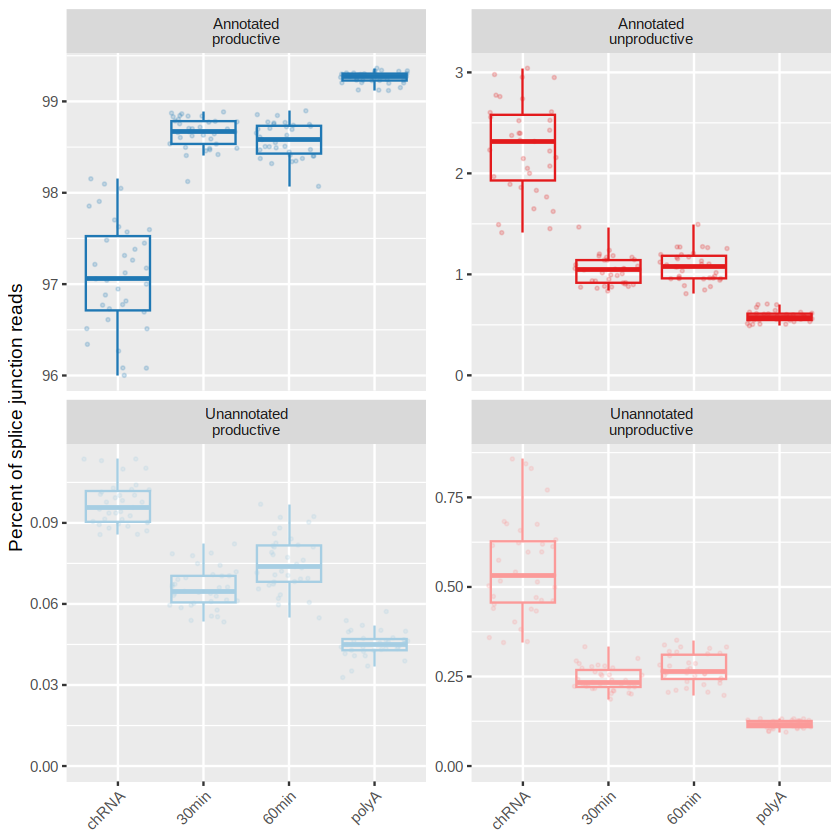

In [9]:
dummy <- P.dat %>%
  distinct(SuperAnnotation, Dataset) %>%
  filter(!SuperAnnotation == "AnnotatedJunc_ProductiveCodingGene") %>%
  mutate(Percent = 0)
P.1.boxplots <- ggplot(P.dat, aes(x=Dataset, y=Percent, color=SuperAnnotation)) +
      geom_jitter(alpha=0.2, size=0.5) +
      geom_boxplot(outlier.shape=NA, fill=NA) +
      geom_blank(data=dummy) +
      scale_color_manual(values = ColorKey) +
      facet_wrap(~SuperAnnotation, nrow=2, scales="free_y",labeller = as_labeller(LabelKey)) +
      theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position = "none") +
      labs(y=str_wrap("Percent of splice junction reads", 32), x=NULL) +
      guides(colour = guide_legend(override.aes4= list(alpha = 1))) +
      # theme(strip.text.x = element_text(size = 7)) +
      theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
      theme(legend.position = "none")
P.1.boxplots


`summarise()` has grouped output by 'SuperAnnotation', 'IndID'. You can override using the `.groups` argument.


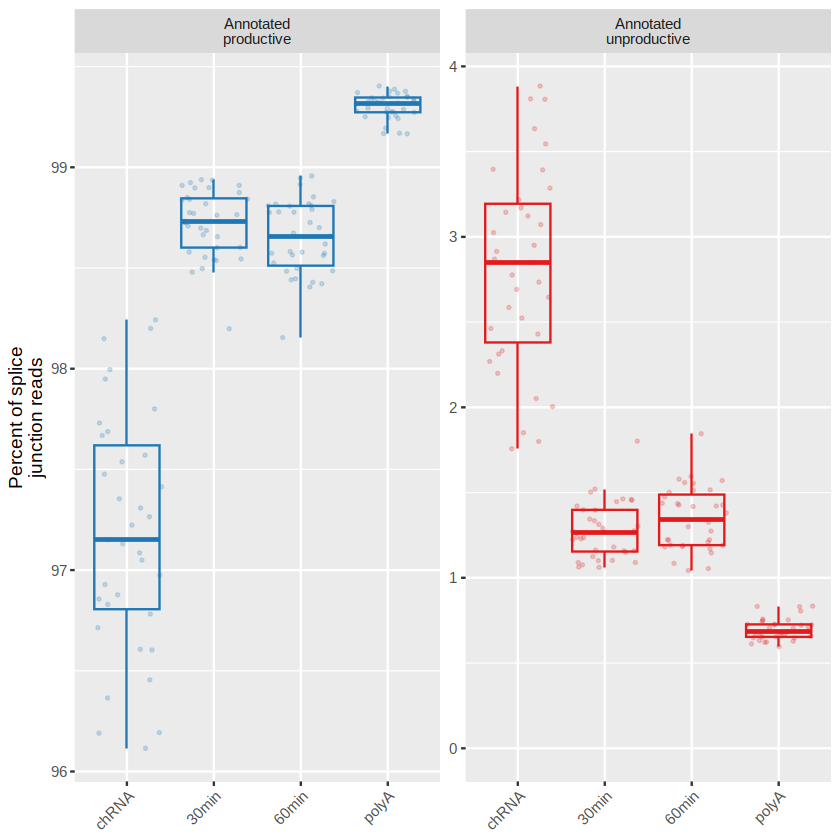

In [10]:
P.1.boxplots_smaller <- P.dat %>%
  mutate(SuperAnnotation = recode(SuperAnnotation, !!!c("UnannotatedJunc_ProductiveCodingGene"="AnnotatedJunc_ProductiveCodingGene", "UnannotatedJunc_UnproductiveCodingGene"="AnnotatedJunc_UnproductiveCodingGene"))) %>%
  group_by(SuperAnnotation, IndID, Dataset) %>%
  summarise(Percent = sum(Percent)) %>%
  ungroup() %>%
ggplot(aes(x=Dataset, y=Percent, color=SuperAnnotation)) +
      geom_jitter(alpha=0.2, size=0.5) +
      geom_boxplot(outlier.shape=NA, fill=NA) +
      geom_blank(data=dummy %>%
                   filter(!str_detect(SuperAnnotation, "Unannotated"))) +
      scale_color_manual(values = ColorKey) +
      facet_wrap(~SuperAnnotation, nrow=1, scales="free_y",labeller = as_labeller(LabelKey)) +
      theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position = "none") +
      labs(y=str_wrap("Percent of splice junction reads", 20), x=NULL) +
      guides(colour = guide_legend(override.aes4= list(alpha = 1))) +
      # theme(strip.text.x = element_text(size = 7)) +
      theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
      theme(legend.position = "none")
P.1.boxplots_smaller